In [35]:
# Extremely simple simulation of a homeostatic controller under allostatic
# modulation (adoptation from the matlab code)

import numpy as np
import pandas as pd  # used only for plotting
from numpy import zeros, ones
from numpy.random import randn
import matplotlib.pyplot as plt

dt = 0.01        # integration step
T = 40           # maximum time considered
sp_m = 1         # homeostatic setpoint: mean
sp_p = 1         # homeostatic setpoint: precision
sp_m_shift = 1   # allostatic shift in setpoint mean between t=10 and t=25
sp_p_tempval = 4 # allostatic setpoint precision between t=32 and t=36
pi_data = 4      # input precision
N = int(T/dt)    # number of steps

# initialise variables
x    = zeros(N) # physiological state
y    = zeros(N) # viscerosensory input
e    = zeros(N) # sensory noise
a    = zeros(N) # visceromotor action
PE   = zeros(N) # prediction error
allo = zeros(N) # allostatic shift in mean
u    = zeros(N) # environmental pertubation

# homeostatic belief (setpoint)
mu_p   = sp_m * ones(N) 
pi_p   = sp_p * ones(N)

allo[int(10/dt):int(25/dt)] = sp_m_shift
mu_p   = mu_p + allo

pi_p[int(32/dt):int(36/dt)] = sp_p_tempval

# environmental pertubations
u[int(3/dt)]  = -1.5
u[int(18/dt)] = -1.5
u[int(34/dt)] = +1.5

# define sensory channel
g    = lambda x: 1 * x # y=g(x) (here: identity relation, for clarity in plot)
dgdx = lambda x: 1     # dg/dx

# sensory noise (variance)
v_e = 1/pi_data

# initializing x and y
x[0] = sp_m
y[0] = g(x[0])+e[0]

for i in range(1, N): 
    # action = dF/dx
    a[i] = -(pi_p[i-1] * (y[i-1]-g(mu_p[i-1])) * dgdx(x[i-1]))
    
    # state change is proportional to action (simple Euler integration)
    x[i] = x[i-1] + dt*a[i] + u[i]
    
    # sensory input = g(x) + channel noise
    e[i]  = randn() * v_e
    y[i]  = g(x[i]) + e[i]
    
    # log squared PE (store for plotting only)
    PE[i] = pi_p[i] * (y[i]-g(mu_p[i]))**2

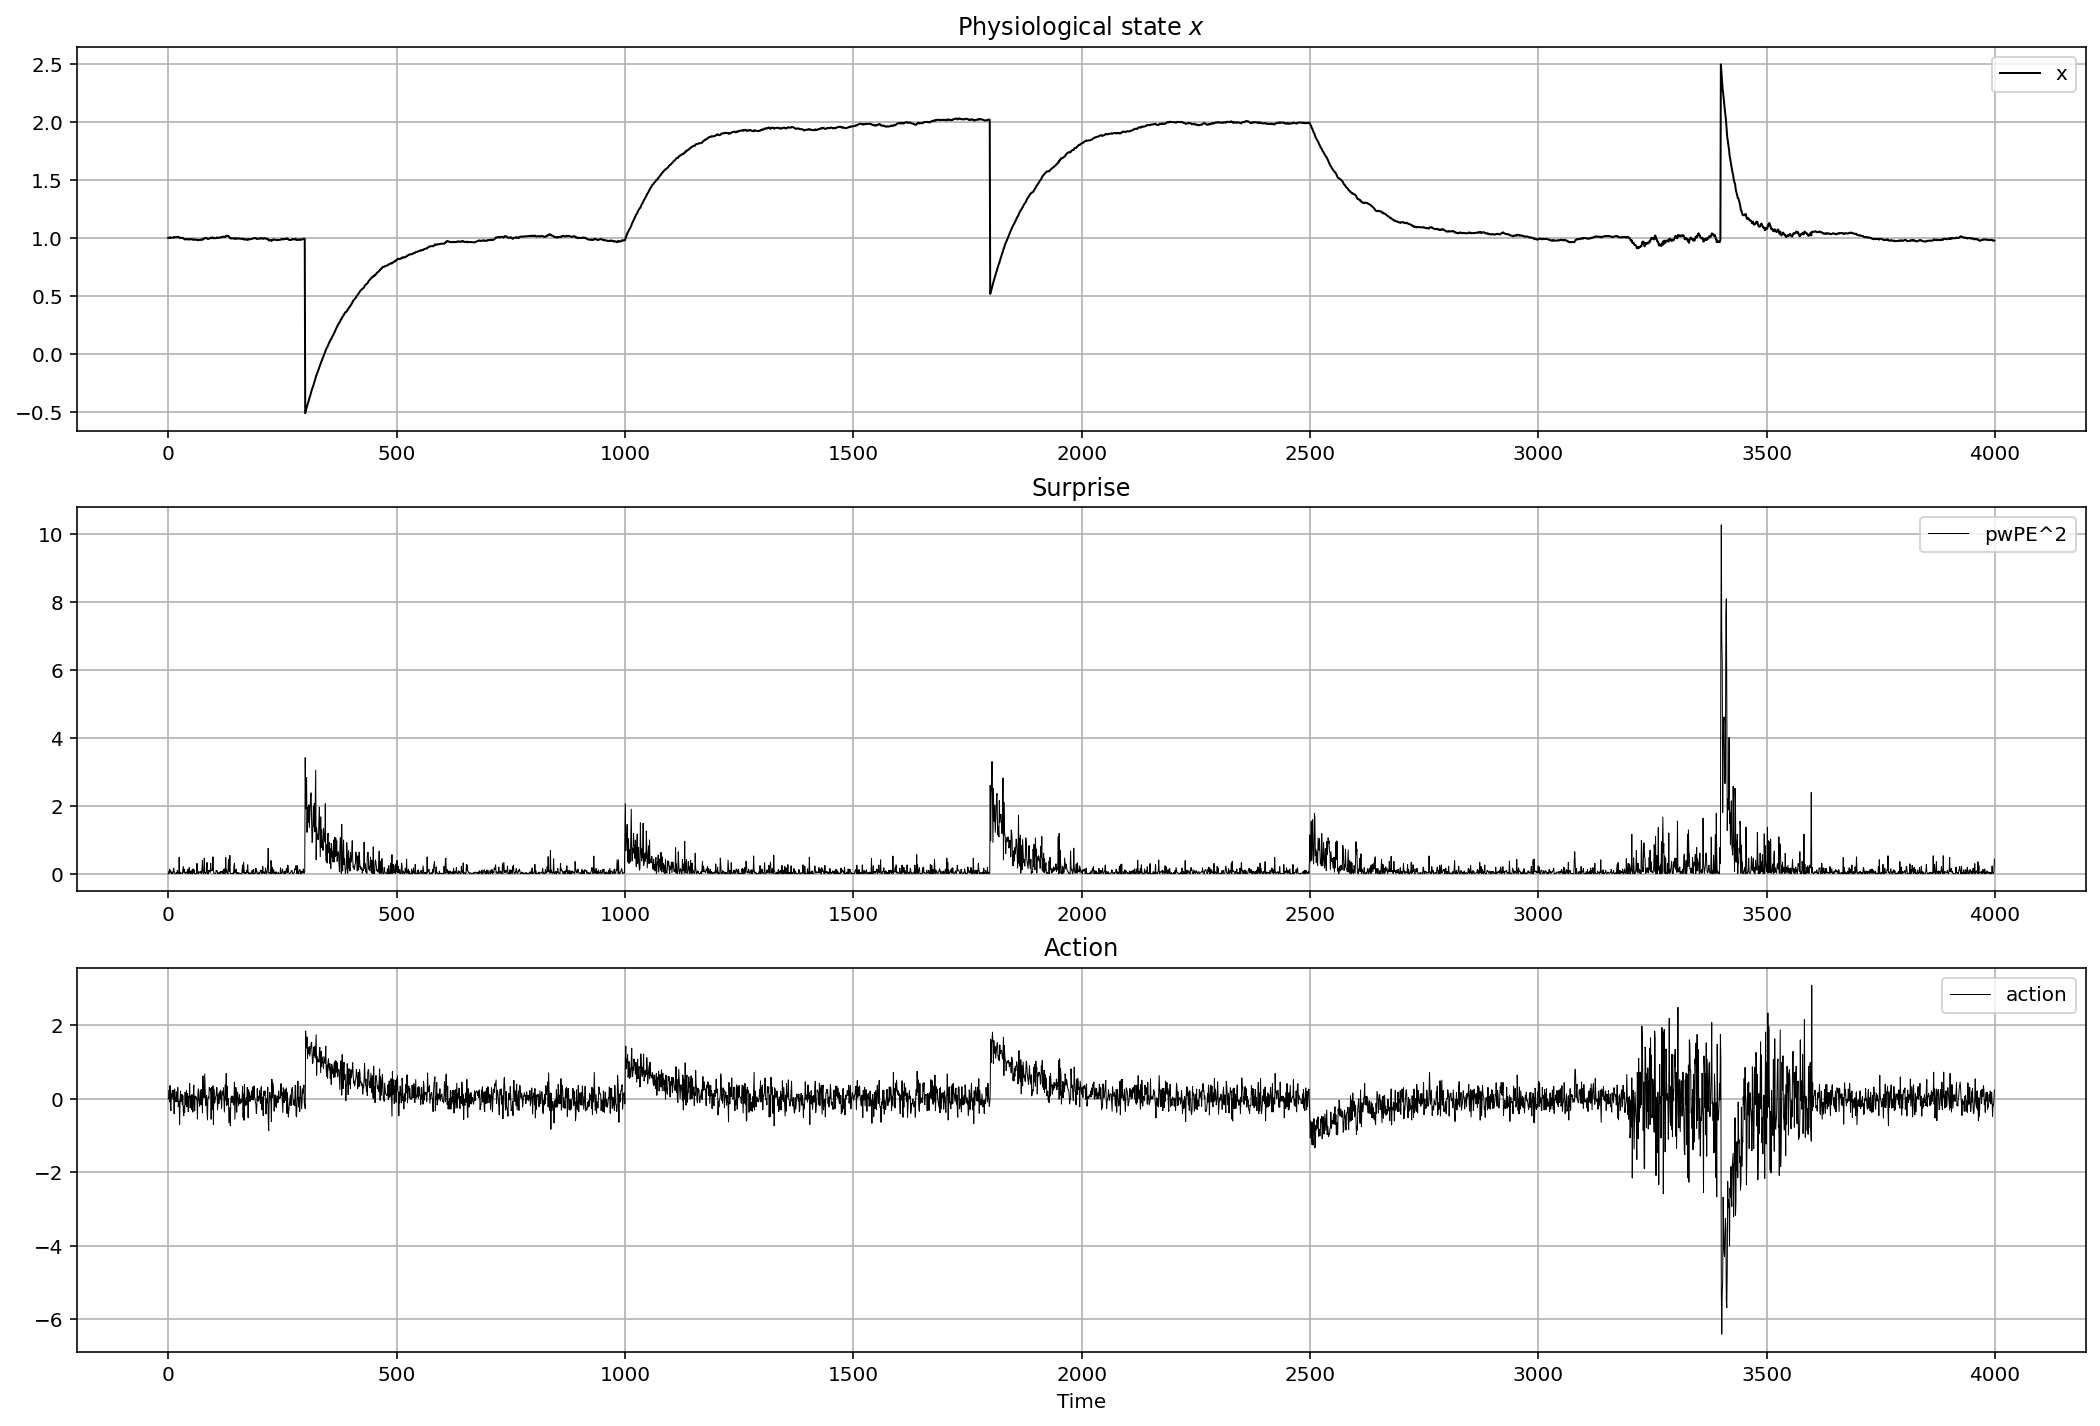

In [37]:
df = pd.DataFrame(data={
    'mu_p':   mu_p, 
    'pi_p':   pi_p,
    'u':      u,
    'x':      x,
    'pwPE^2': PE,
    'action': a
})

fig, axs = plt.subplots(3, 1, figsize=(18,12))
df[['x']].plot(ax=axs[0], lw=1, C="0", grid=True, title=r'Physiological state $x$')
df[['pwPE^2']].plot(ax=axs[1], C="0", lw=0.5, grid=True, title=r'Surprise')
df[['action']].plot(ax=axs[2], lw=0.5, C="0", grid=True, title=r'Action')
axs[2].set_xlabel("Time");